In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pickle, json
import astropy.constants as c
import astropy.units as u
from mpmath import *
from sympy import *
import sympy
from sympy.solvers import solve
from sympy.plotting import plot

In [13]:
# symbolic calculation
x = symbols('x')
a = Integral(cos(x)*exp(x), x)
Eq(a, a.doit())

Eq(Integral(exp(x)*cos(x), x), exp(x)*sin(x)/2 + exp(x)*cos(x)/2)

t0 = 1.4809609793861218
period = 8.885765876316732


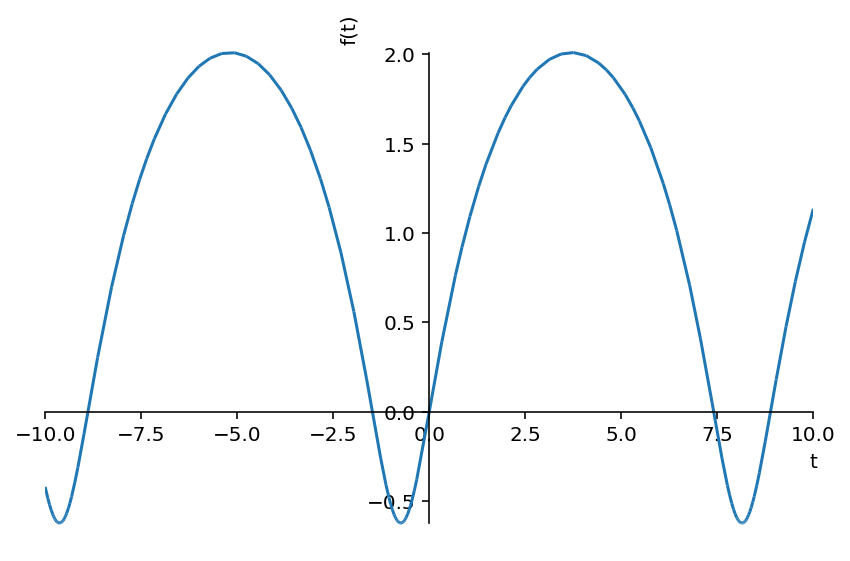

In [22]:
# problem 1a
x, t = symbols('x, t') 

# bound solution
E = -0.25
t0 = (1/np.sqrt(2*abs(E))) * np.arcsin(np.sqrt(1-abs(E)))
T = 2*np.pi/np.sqrt(2*abs(E))
print('t0 =', t0)
print('period =', T)

x = log( (1/abs(E)) * (1 + np.sqrt(1-abs(E)) * sin(np.sqrt(2*abs(E)) * (t-t0)) )  )
plot(x)